In [1]:
import numpy as np
import pandas as pd
import warnings
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.integrate import ODEintWarning

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

viridis_pal = sns.color_palette('viridis', n_colors=8)
rocket_pal = sns.color_palette('rocket', n_colors=3)

## 1. Lotka-Volterra (Cycle model)

\begin{align}
\dot X_1 &= - a_1 X_1 - a_2 X_1 X_2 + a_3 X_1 X_3 \\
\dot X_2 &= a_4 X_1 X_2 - a_5 X_2 - a_6 X_2 X_3 \\
\dot X_3 &= -a_7 X_1 X_3 + a_8 X_2 X_3 - a_9 X_3 \\
\end{align}

In [2]:
def modelLV(X, t, params):
    a1, a2, a3, a4, a5, a6, a7, a8, a9 = params
    X1, X2, X3 = X

    # Prevent negative or huge values
    X1 = np.clip(X1, 0, 1e6)
    X2 = np.clip(X2, 0, 1e6)
    X3 = np.clip(X3, 0, 1e6)
    
    dX1 = - a1*X1 - a2*X1*X2 + a3*X1*X3
    dX2 = a4*X1*X2 - a5*X2 - a6*X2*X3
    dX3 = -a7*X1*X3 + a8*X2*X3 - a9*X3
    
    return [dX1, dX2, dX3]

In [3]:
# Ground truth values
a1 = 0.18
a2 = 0.16 
a3 = 0.15 
a4 = 0.11 
a5 = 0.02 
a6 = 0.12 
a7 = 0.04 
a8 = 0.12 
a9 = 0.02

groundParams = np.array([a1, a2, a3, a4, a5, a6, a7, a8, a9])

In [4]:
# Initial conditions
X0 = [4, 2, 1]

t = np.linspace(0, 80, 161)

sol = odeint(modelLV, X0, t, args=(groundParams,))

X1_g = sol[:,0]
X2_g = sol[:,1]
X3_g = sol[:,2]

## 2. Import data

In [5]:
dfData_A = pd.read_csv('cycle/LVdata_noise.csv')

In [6]:
dfWindows = pd.read_csv('cycle/qualX3cell.csv')

In [7]:
dfData_B1 = pd.read_csv('cycle/LVdata_X3noise_1.csv')
dfData_B2 = pd.read_csv('cycle/LVdata_X3noise_2.csv')
dfData_B3 = pd.read_csv('cycle/LVdata_X3noise_3.csv')
dfData_B4 = pd.read_csv('cycle/LVdata_X3noise_4.csv')

## 3. Cost function

In [8]:
def rss(data_A, interp_func):
    try:
        times = data_A[:, 0]
        obs = data_A[:, 1]

        # Find unique times and how many replicates there are per time
        unique_times, counts = np.unique(times, return_counts=True)

        # Interpolate model at unique time points
        model_values = interp_func(unique_times)

        # Repeat to match number of replicates
        model_repeated = np.repeat(model_values, counts)

        diff = obs - model_repeated
        if not np.all(np.isfinite(diff)):
            return 1e6

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            rss = np.sum(diff ** 2)

        if not np.isfinite(rss):
            return 1e6
        
        return rss

    except Exception:
        return 1e6

### 3.1 Step penalty

In [9]:
def costFunction(params, model, data_A, windows=None, use_windows=True,
                  num_variables=3, rss_variable=0, window_variable=2, penalty_value=1e6):
    try:
        # Initial conditions
        X0 = [4, 2, 1]

        # Time range
        t_max_A = np.max(data_A[:, 0])
        if use_windows and windows is not None:
            t_max = max(t_max_A, np.max(windows[:, 1]))
        else:
            t_max = t_max_A

        t_eval = np.linspace(0, t_max, 1000)

        # Solve ODE model
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ODEintWarning)
            warnings.simplefilter("ignore", RuntimeWarning)
            sol = odeint(model, X0, t_eval, args=(params,))

        if not np.all(np.isfinite(sol)):
            return penalty_value #* np.random.uniform(1, 2)

        # Window constraint check
        if use_windows and windows is not None:
            var_w = sol[:, window_variable]
            for row in windows:
                tmin, tmax, vmin, vmax = row
                mask = (t_eval >= tmin) & (t_eval <= tmax)
                if not np.any((var_w[mask] >= vmin) & (var_w[mask] <= vmax)):
                    return penalty_value #* np.random.uniform(1, 2)

        # RSS computation
        var_rss = sol[:, rss_variable]
        interp_func = interp1d(t_eval, var_rss, kind='linear', bounds_error=False, fill_value='extrapolate')
        return rss(data_A, interp_func)

    except Exception:
        return penalty_value #* np.random.uniform(1, 2)

### 3.2 Hinge penalty (linear growth)

In [10]:
def costFunction_hinge(params, model, data_A, windows=None, use_windows=True,
                  num_variables=3, rss_variable=0, window_variable=2,
                  penalty_weight=1e3):
    try:
        # Initial conditions
        X0 = [4, 2, 1]

        # Time range
        t_max_A = np.max(data_A[:, 0])
        if use_windows and windows is not None:
            t_max = max(t_max_A, np.max(windows[:, 1]))
        else:
            t_max = t_max_A

        t_eval = np.linspace(0, t_max, 1000)

        # Solve ODE model
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ODEintWarning)
            warnings.simplefilter("ignore", RuntimeWarning)
            sol = odeint(model, X0, t_eval, args=(params,))
            
        if not np.all(np.isfinite(sol)):
            return 1e6

        # RSS
        var_rss = sol[:, rss_variable]
        interp_func = interp1d(t_eval, var_rss, kind='linear', bounds_error=False, fill_value='extrapolate')
        rss_cost = rss(data_A, interp_func)

        # Hinge penalty for windows
        penalty_sum = 0.0
        if use_windows and windows is not None:
            var_w = sol[:, window_variable]
            for row in windows:
                tmin, tmax, vmin, vmax = row
                mask = (t_eval >= tmin) & (t_eval <= tmax)
                values = var_w[mask]

                below_dist = np.maximum(0.0, vmin - values)
                above_dist = np.maximum(0.0, values - vmax)
                outside_dist = below_dist + above_dist

                penalty_sum += np.mean(outside_dist)

        # Total cost: RSS + soft penalty
        return rss_cost + penalty_weight * penalty_sum

    except Exception:
        return 1e6

### 3.3 Soft penalty (logistic)

In [11]:
def costFunction_logistic(params, model, data_A, windows=None, use_windows=True,
                          num_variables=3, rss_variable=0, window_variable=2,
                          penalty_weight=1e3, alpha=50.0):
    try:
        # Initial conditions
        X0 = [4, 2, 1]

        # Determine simulation time
        t_max_A = np.max(data_A[:, 0])
        if use_windows and windows is not None:
            t_max = max(t_max_A, np.max(windows[:, 1]))
        else:
            t_max = t_max_A

        t_eval = np.linspace(0, t_max, 1000)

        # Solve ODE
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ODEintWarning)
            warnings.simplefilter("ignore", RuntimeWarning)
            sol = odeint(model, X0, t_eval, args=(params,))

        # If integration fails
        if not np.all(np.isfinite(sol)):
            return 1e6

        # RSS (data fit term)
        var_rss = sol[:, rss_variable]
        interp_func = interp1d(
            t_eval, var_rss, kind='linear', bounds_error=False, fill_value='extrapolate'
        )
        rss_cost = rss(data_A, interp_func)

        # Smooth window penalty
        penalty_sum = 0.0
        if use_windows and windows is not None:
            var_w = sol[:, window_variable]
            for row in windows:
                tmin, tmax, vmin, vmax = row
                mask = (t_eval >= tmin) & (t_eval <= tmax)
                values = var_w[mask]

                below_dist = np.maximum(0.0, vmin - values)
                above_dist = np.maximum(0.0, values - vmax)
                outside_dist = below_dist + above_dist

                penalty = outside_dist / (1.0 + np.exp(-alpha * outside_dist))

                penalty_sum += np.mean(penalty)

        # Total cost = RSS + weighted penalty
        return rss_cost + penalty_weight * penalty_sum

    except Exception:
        return 1e6

In [12]:
# Compute cost using ground truth
cost = costFunction(
    params=groundParams,
    model=modelLV,          # model function
    data_A=dfData_A.values,      # dataset A
    windows=dfWindows.values,    # window constraints
    use_windows=False,            # or False to use only RSS
    num_variables=3,
    rss_variable=0,
    window_variable=2,
    penalty_value=1e6
)

print(f"Total cost: {cost}")

Total cost: 1.222251670051275


## 4. Recovering parameters

In [13]:
# Define parameter bounds in the specified order
bounds = [
    (5e-2, 5e-1),  # a1
    (5e-2, 5e-1),  # a2
    (5e-2, 5e-1),  # a3
    (5e-2, 5e-1),  # a4
    (1e-2, 1e-1),  # a5
    (5e-2, 5e-1),  # a6
    (1e-2, 1e-1),  # a7
    (5e-2, 5e-1),  # a8
    (1e-2, 1e-1),  # a9
]

### 4.1. Step penalty
#### 4.1.1 Differential Evolution (DE)

In [13]:
from scipy.optimize import differential_evolution

#### 4.1.2 Dual Annealing (DA)

In [14]:
from scipy.optimize import dual_annealing

#### 4.3. Simplicial Homology Global Optimization (SHGO)

In [15]:
from scipy.optimize import shgo

In [76]:
# Load parameters
bestParams_noWin_DE = np.loadtxt("test/bestParams_noWin_DE.csv", delimiter=",", skiprows=1)
bestParams_win_DE = np.loadtxt("test/bestParams_win_DE.csv", delimiter=",", skiprows=1)

bestParams_noWin_DA = np.loadtxt("test/bestParams_noWin_DA.csv", delimiter=",", skiprows=1)
bestParams_win_DA = np.loadtxt("test/bestParams_win_DA.csv", delimiter=",", skiprows=1)

bestParams_noWin_SHGO = np.loadtxt("test/bestParams_noWin_SHGO.csv", delimiter=",", skiprows=1)
bestParams_win_SHGO = np.loadtxt("test/bestParams_win_SHGO.csv", delimiter=",", skiprows=1)

In [77]:
# Solve model using optimized parameters
t = np.linspace(0, 80, 161)
X0 = [4, 2, 1]

# DE
solution = odeint(modelLV, X0, t, args=(bestParams_noWin_DE,))
X1_noWin_DE, X2_noWin_DE, X3_noWin_DE = solution.T

solution = odeint(modelLV, X0, t, args=(bestParams_win_DE,))
X1_win_DE, X2_win_DE, X3_win_DE = solution.T

# DA
solution = odeint(modelLV, X0, t, args=(bestParams_noWin_DA,))
X1_noWin_DA, X2_noWin_DA, X3_noWin_DA = solution.T

solution = odeint(modelLV, X0, t, args=(bestParams_win_DA,))
X1_win_DA, X2_win_DA, X3_win_DA = solution.T

# SHGO
solution = odeint(modelLV, X0, t, args=(bestParams_noWin_SHGO,))
X1_noWin_SHGO, X2_noWin_SHGO, X3_noWin_SHGO = solution.T

solution = odeint(modelLV, X0, t, args=(bestParams_win_SHGO,))
X1_win_SHGO, X2_win_SHGO, X3_win_SHGO = solution.T

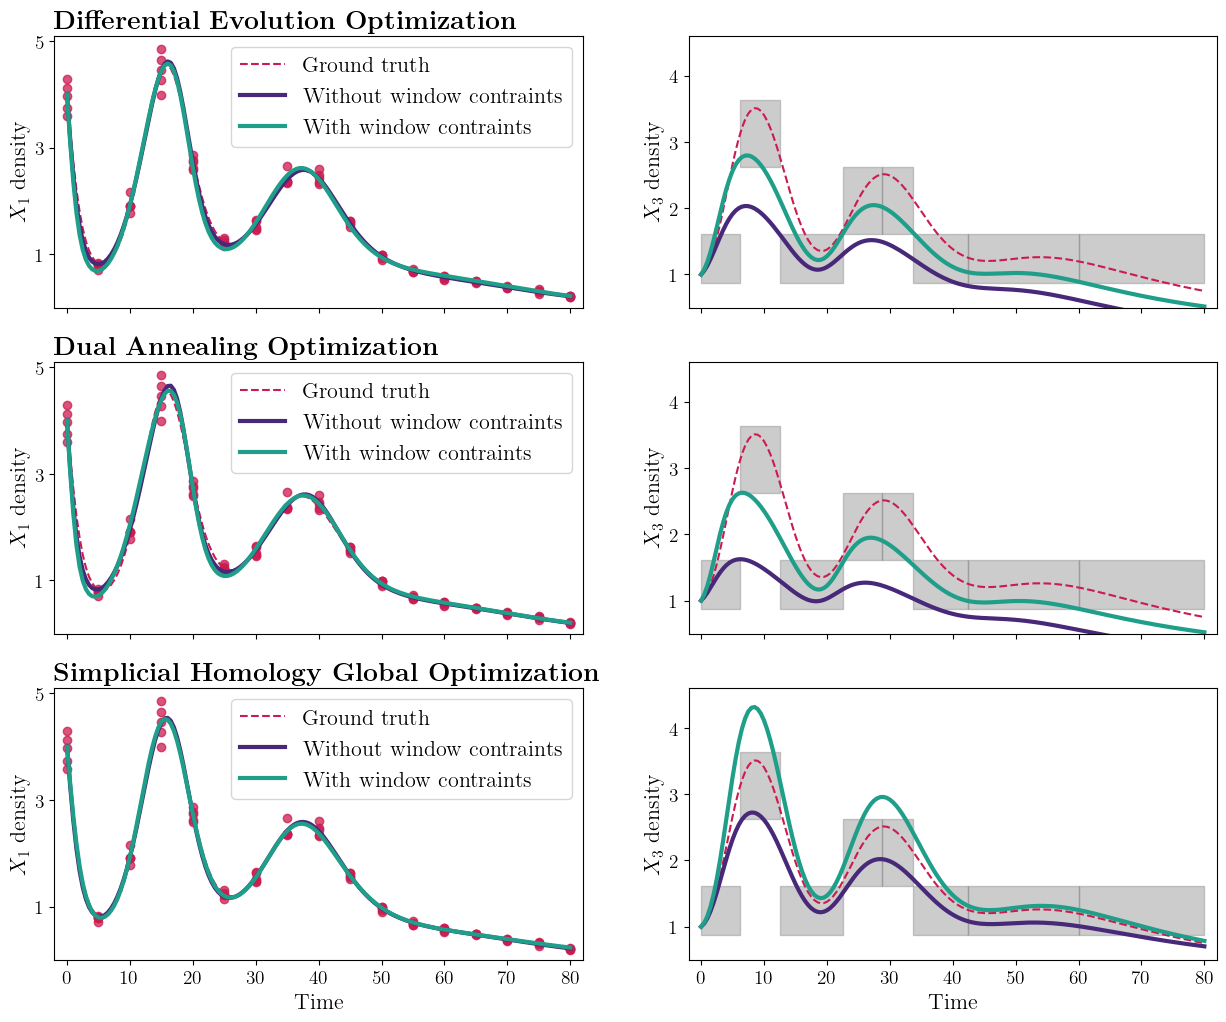

In [78]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,12), sharex=True)

# Row 1: DE
ax[0,0].set_title(r'\bf{Differential Evolution Optimization}', loc='left')
ax[0,0].scatter(x=dfData_A['Time'], y=dfData_A['X1'], color=rocket_pal[1], marker="o", alpha=0.75)
ax[0,0].plot(t, X1_g, lw=1.5, color=rocket_pal[1], ls='--', label='Ground truth')
ax[0,0].plot(t, X1_noWin_DE, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[0,0].plot(t, X1_win_DE, lw=3, color=viridis_pal[4], label='With window contraints')
ax[0,0].legend()


ax[0,1].plot(t, X3_g, lw=1.5, color=rocket_pal[1], ls='--')
ax[0,1].plot(t, X3_noWin_DE, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[0,1].plot(t, X3_win_DE, lw=3, color=viridis_pal[4], label='With window contraints')

# Row 2: DA
ax[1,0].set_title(r'\bf{Dual Annealing Optimization}', loc='left')
ax[1,0].scatter(x=dfData_A['Time'], y=dfData_A['X1'], color=rocket_pal[1], marker="o", alpha=0.75)
ax[1,0].plot(t, X1_g, lw=1.5, color=rocket_pal[1], ls='--', label='Ground truth')
ax[1,0].plot(t, X1_noWin_DA, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[1,0].plot(t, X1_win_DA, lw=3, color=viridis_pal[4], label='With window contraints')
ax[1,0].legend()


ax[1,1].plot(t, X3_g, lw=1.5, color=rocket_pal[1], ls='--')
ax[1,1].plot(t, X3_noWin_DA, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[1,1].plot(t, X3_win_DA, lw=3, color=viridis_pal[4], label='With window contraints')

# Row 3: SHGO
ax[2,0].set_title(r'\bf{Simplicial Homology Global Optimization}', loc='left')
ax[2,0].scatter(x=dfData_A['Time'], y=dfData_A['X1'], color=rocket_pal[1], marker="o", alpha=0.75)
ax[2,0].plot(t, X1_g, lw=1.5, color=rocket_pal[1], ls='--', label='Ground truth')
ax[2,0].plot(t, X1_noWin_SHGO, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[2,0].plot(t, X1_win_SHGO, lw=3, color=viridis_pal[4], label='With window contraints')
ax[2,0].legend()


ax[2,1].plot(t, X3_g, lw=1.5, color=rocket_pal[1], ls='--')
ax[2,1].plot(t, X3_noWin_SHGO, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[2,1].plot(t, X3_win_SHGO, lw=3, color=viridis_pal[4], label='With window contraints')

# Overlay window constraints
for _, row in dfWindows.iterrows():
    tmin, tmax = row['Tmin'], row['Tmax']
    x3min, x3max = row['X3min'], row['X3max']
    for i in range(3):
        ax[i,1].fill_betweenx(
            [x3min, x3max], tmin, tmax, color='gray', alpha=0.4, label='Window' if _ == 0 else None
        )

ax[2,0].set_xlabel('Time')
ax[2,1].set_xlabel('Time')

for i in range(3):
    ax[i,0].set_ylabel('$X_1$ density')
    ax[i,1].set_ylabel('$X_3$ density')
    
    ax[i,0].set_ylim((0.0,5.1))
    ax[i,1].set_ylim((0.5,4.6))
    ax[i,0].set_yticks(np.arange(1, 6, 2))
    ax[i,1].set_yticks(np.arange(1, 5, 1))

plt.setp(ax, xlim=(-2,82))

# plt.savefig('testingOptimizers.png')

plt.show()

### 4.2 Continuos penalty
#### 4.2.1 Hinge penalty

In [79]:
# Particle Swarm Optimization
import pyswarms as ps

In [80]:
%%time

def pso_cost_wrapper(particles):
    costs = []
    for params in particles:
        cost_val = costFunction_logistic(
            params=params,
            model=modelLV,
            data_A=dfData_A.values,
            windows=dfWindows.values,
            use_windows=False,
            num_variables=3,
            rss_variable=0,
            window_variable=2,
            alpha=20
        )
        costs.append(cost_val)
    return np.array(costs)

# Number of parameters (same as DE)
dim = len(bounds)

# Extract lower/upper bounds for PSO
lb = [b[0] for b in bounds]
ub = [b[1] for b in bounds]
bounds_pso = (np.array(lb), np.array(ub))

# Configure PSO hyperparameters
options = {
    'c1': 0.5,    # cognitive coefficient
    'c2': 0.3,    # social coefficient
    'w': 0.9      # inertia weight
}

# Initialize PSO optimizer
optimizer = ps.single.GlobalBestPSO(
    n_particles=200,  # swarm size
    dimensions=dim,  # number of parameters
    options=options,
    bounds=bounds_pso
)

# Run optimization
cost, best_position = optimizer.optimize(pso_cost_wrapper, iters=5000)

print("Best cost (PSO):", cost)
print("Best parameters:", best_position)

bestParams_noWin_PSO = best_position

2025-07-25 15:39:37,546 - pyswarms.single.global_best - INFO - Optimize for 5000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████|5000/5000, best_cost=1.44
2025-07-25 17:34:19,734 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.4388462120802796, best pos: [0.17503138 0.32547086 0.23120802 0.20928898 0.04082024 0.33368091
 0.01398555 0.11212733 0.02724223]


Best cost (PSO): 1.4388462120802796
Best parameters: [0.17503138 0.32547086 0.23120802 0.20928898 0.04082024 0.33368091
 0.01398555 0.11212733 0.02724223]
CPU times: user 1h 54min 41s, sys: 1.83 s, total: 1h 54min 43s
Wall time: 1h 54min 42s


In [106]:
%%time

def pso_cost_wrapper(particles):
    costs = []
    for params in particles:
        cost_val = costFunction_hinge(
            params=params,
            model=modelLV,
            data_A=dfData_A.values,
            windows=dfWindows.values,
            use_windows=True,
            num_variables=3,
            rss_variable=0,
            window_variable=2#,
            #alpha=20
        )
        costs.append(cost_val)
    return np.array(costs)

# Number of parameters (same as DE)
dim = len(bounds)

# Extract lower/upper bounds for PSO
lb = [b[0] for b in bounds]
ub = [b[1] for b in bounds]
bounds_pso = (np.array(lb), np.array(ub))

# Configure PSO hyperparameters
options = {
    'c1': 0.5,    # cognitive coefficient
    'c2': 0.3,    # social coefficient
    'w': 0.9      # inertia weight
}

# Initialize PSO optimizer
optimizer = ps.single.GlobalBestPSO(
    n_particles=400,  # swarm size
    dimensions=dim,  # number of parameters
    options=options,
    bounds=bounds_pso
)

# Run optimization
cost, best_position = optimizer.optimize(pso_cost_wrapper, iters=10000)

print("Best cost (PSO):", cost)
print("Best parameters:", best_position)

bestParams_win_PSO = best_position

2025-07-31 14:02:18,855 - pyswarms.single.global_best - INFO - Optimize for 10000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████|10000/10000, best_cost=444
2025-08-01 00:31:13,604 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 444.1982555097349, best pos: [0.21663882 0.30886218 0.27092848 0.14661368 0.02683562 0.13718231
 0.04164221 0.09268353 0.01034893]


Best cost (PSO): 444.1982555097349
Best parameters: [0.21663882 0.30886218 0.27092848 0.14661368 0.02683562 0.13718231
 0.04164221 0.09268353 0.01034893]
CPU times: user 10h 28min 50s, sys: 4.47 s, total: 10h 28min 55s
Wall time: 10h 28min 54s


In [14]:
# Load parameters
bestParams_noWin_PSO = np.loadtxt("test/bestParams_noWin_PSO.csv", delimiter=",", skiprows=1)
bestParams_win_PSO = np.loadtxt("test/bestParams_win_PSO.csv", delimiter=",", skiprows=1)

In [15]:
# Solve model using optimized parameters
t = np.linspace(0, 80, 161)
X0 = [4, 2, 1]

solution = odeint(modelLV, X0, t, args=(bestParams_noWin_PSO,))
X1_noWin_PSO, X2_noWin_PSO, X3_noWin_PSO = solution.T

solution = odeint(modelLV, X0, t, args=(bestParams_win_PSO,))
X1_win_PSO, X2_win_PSO, X3_win_PSO = solution.T

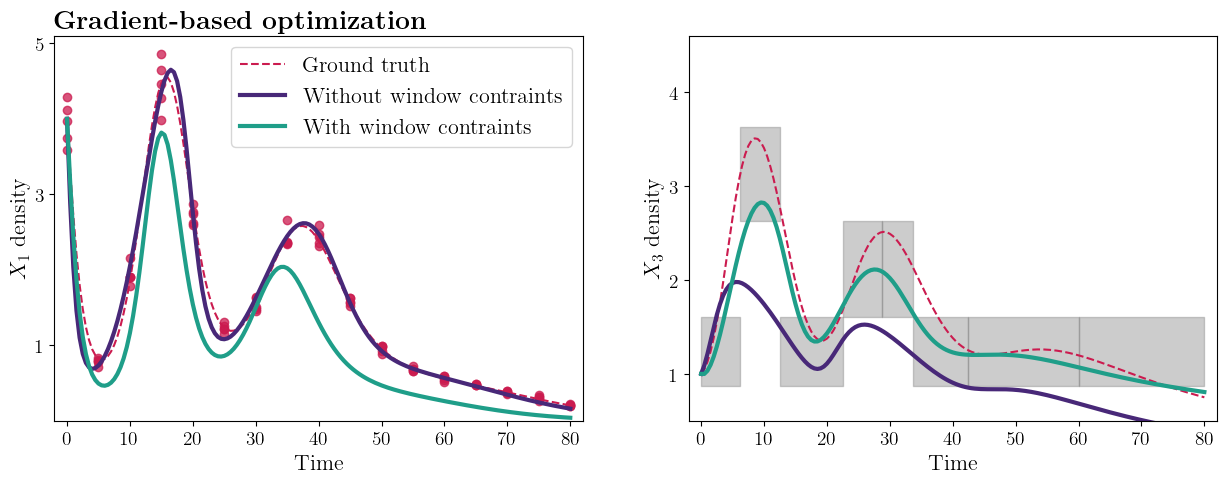

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharex=True)

ax[0].set_title(r'\bf{Gradient-based optimization}', loc='left')
ax[0].scatter(x=dfData_A['Time'], y=dfData_A['X1'], color=rocket_pal[1], marker="o", alpha=0.75)
ax[0].plot(t, X1_g, lw=1.5, color=rocket_pal[1], ls='--', label='Ground truth')
ax[0].plot(t, X1_noWin_PSO, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[0].plot(t, X1_win_PSO, lw=3, color=viridis_pal[4], label='With window contraints')
ax[0].legend()


ax[1].plot(t, X3_g, lw=1.5, color=rocket_pal[1], ls='--')
ax[1].plot(t, X3_noWin_PSO, lw=3, color=viridis_pal[0], label='Without window contraints')
ax[1].plot(t, X3_win_PSO, lw=3, color=viridis_pal[4], label='With window contraints')

# Overlay window constraints
for _, row in dfWindows.iterrows():
    tmin, tmax = row['Tmin'], row['Tmax']
    x3min, x3max = row['X3min'], row['X3max']
    ax[1].fill_betweenx(
        [x3min, x3max], tmin, tmax, color='gray', alpha=0.4, label='Window' if _ == 0 else None
    )

ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')

ax[0].set_ylabel('$X_1$ density')
ax[1].set_ylabel('$X_3$ density')

ax[0].set_ylim((0.0,5.1))
ax[1].set_ylim((0.5,4.6))
ax[0].set_yticks(np.arange(1, 6, 2))
ax[1].set_yticks(np.arange(1, 5, 1))

plt.setp(ax, xlim=(-2,82))

# plt.savefig('testingLogisitic.png')

plt.show()